In [18]:
import cbsodata
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.json import json_normalize 
from shapely import wkt
from zipfile import ZipFile
from urllib.request import urlopen
from io import BytesIO

## Energielabels per buurt

Download gegevens uit de [Klimaatmonitor](https://klimaatmonitor.databank.nl/Jive?report=buurt_klimaatmonitor2018) als CSV-bestand en lees de gegevens in. 
<img src="./img/img1.png">
<img src="./img/img2.png" style="width: 50%;"/>
<img src="./img/img3.png" style="width: 50%;"/>

In [6]:
klimaatmonitor = pd.read_excel('./data/Klimaatmonitor.xls',  sep = ";")
klimaatmonitor.rename({"Code": "buurtcode", "Gebieden": "buurtnaam"}, axis = 'columns', inplace = True)
klimaatmonitor['buurtcode'] = klimaatmonitor['buurtcode'].apply(lambda x: 'BU{0:0>8}'.format(x))
print(klimaatmonitor.shape)

(2186, 71)


## Provinciegrens

Vraag de provinciegrens van Zuid-Holland op bij de WFS-service [Bestuurlijke Grenzen](https://www.pdok.nl/introductie/-/article/bestuurlijke-grenzen) van PDOK. 

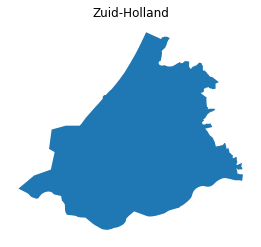

In [3]:
url = 'https://geodata.nationaalgeoregister.nl/bestuurlijkegrenzen/wfs?'\
      'request=GetFeature&service=wfs&outputFormat=json&typeName=bestuurlijkegrenzen:provincies'
provincie = gpd.read_file(url).loc[lambda x: x['provincienaam'] == 'Zuid-Holland']
ax = provincie.plot()
ax.set_title("Zuid-Holland")
ax.set_axis_off()
plt.show()
del url, ax

## Buurtgrenzen

Vraag de buurtgrenzen op bij de WFS-service [Bestand Wijken en Buurten](https://www.pdok.nl/introductie/-/article/cbs-wijken-en-buurten) van het CBS. De metadata is te vinden in de [toelichting](https://www.cbs.nl/-/media/cbs/dossiers/nederland%20regionaal/wijk-en-buurtstatistieken/2018/2018ep42%20toelichting%20buurtkaart%202018.pdf).

Geef bij het request de bounding box van de provincie Zuid-Holland, zodat niet alle buurten in Nederland geretourneerd worden.    
Filter buurten op de provinciegrens. Omdat de buurtgrenzen soms ruimer zijn dan de provinciegrens, geeft een spatial join met als operator `within` te weinig buurten terug. Los dit op door te filteren op een buffer van 100 meter bovenop de provinciegrens.

In [4]:
provincie.bounds

,minx,miny,maxx,maxy
9,43662.62,406692.0,130480.876,483120.0


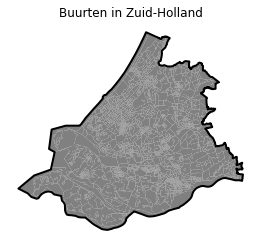

In [5]:
bbox = '43000,406000,131000,484000'
url = 'https://geodata.nationaalgeoregister.nl/wijkenbuurten2018/wfs?' \
      'service=wfs&request=getfeature&typeName=cbs_buurten_2018&outputFormat=json&' \
      'bbox=' + bbox
provincie_buffered = provincie.copy()
provincie_buffered.geometry = provincie.geometry.buffer(100)
buurten = gpd.sjoin(gpd.read_file(url), provincie_buffered, op = 'within')
ax = buurten.plot(facecolor = 'grey')
provincie.plot(facecolor =  'none', edgecolor = 'black', lw = 2, ax = ax)
ax.set_title('Buurten in Zuid-Holland')
ax.set_axis_off()
plt.show()
del url, ax

In de Klimaatmonitor zitten minder buurten dan in het Bestand Wijken en Buurten. Hoe kan dat?

In [7]:
print(f'''Klimaatmonitor: {klimaatmonitor.shape[0]} rijen''')
print(f'''Bestand Wijken en Buurten: {buurten.shape[0]} rijen''')

Klimaatmonitor: 2186 rijen
Bestand Wijken en Buurten: 2202 rijen


In [8]:
df = pd.merge(buurten, klimaatmonitor, on = 'buurtcode', how = 'outer', suffixes=(['_cbs', '_km']))
df[['buurtcode', 'buurtnaam_cbs', 'buurtnaam_km', 'water']].loc[df.buurtnaam_km.isnull()]

,buurtcode,buurtnaam_cbs,buurtnaam_km,water
5,BU19249997,None,NaN,JA
6,BU19249998,None,NaN,JA
7,BU19309997,None,NaN,JA
2189,BU06179997,None,NaN,JA
2190,BU06299998,None,NaN,JA
2191,BU05059997,None,NaN,JA
2192,BU05189998,None,NaN,JA
2193,BU05309997,None,NaN,JA
2194,BU05309998,None,NaN,JA
2195,BU05379998,None,NaN,JA


Het gaat dus om buurten die in het water liggen en geen naam hebben. Verwijder deze buurten.

In [9]:
df = df.loc[~df.buurtnaam_km.isnull()]

df.rename({'buurtnaam_cbs' : 'buurtnaam'}, axis = 'columns', inplace = True)

print(f'''{df.shape[0]} rijen''')

2186 rijen


# Wijken

Voeg voor de volledigheid ook de wijknaam toe aan de dataset. Deze kun je opvragen bij PDOK LocatieServer.

In [10]:
url = "https://geodata.nationaalgeoregister.nl/locatieserver/v3/free?" \
      "q=provincienaam:'Zuid-Holland'&fq=type:wijk&fl=wijkcode,wijknaam&rows=1000"

wijken = json_normalize(pd.read_json(url).response.docs)

test = pd.merge(df, wijken, on = 'wijkcode', how = 'left')


Verwijder alle kolommen die dubbel of niet relevant zijn.

In [11]:
c = ['id_left', 'aantal_inwoners', 'aantal_huishoudens', 'gemiddelde_huishoudsgrootte', 'gemeentecode', \
     'indelingswijziging_wijken_en_buurten_indicator', 'buurtnaam_km', 'meest_voorkomende_postcode', \
     'water', 'index_right', 'id_right', 'wijkcode', 'provincienaam', 'dekkingspercentage']

df.drop(c, axis = 1, inplace = True)

del c

## Kerncijfers per buurt

Het CBS publiceert voor ieder jaar 'Kerncijfers Wijken en Buurten'.

In [12]:
json_normalize(cbsodata.get_table_list(select = ['Identifier', 'Title'])) \
  .loc[lambda x: x['Title'].str.startswith('Kerncijfers wijken en buurten')] \
  .sort_values('Title')

,Identifier,Title
3246,37108,Kerncijfers wijken en buurten 1995
3245,37515,Kerncijfers wijken en buurten 1997
3244,37681,Kerncijfers wijken en buurten 1999
3243,70139NED,Kerncijfers wijken en buurten 2001
3242,80868ned,Kerncijfers wijken en buurten 2003
3241,81903NED,Kerncijfers wijken en buurten 2004-2008
3240,70904ned,Kerncijfers wijken en buurten 2009-2012
962,82339NED,Kerncijfers wijken en buurten 2013
961,82931NED,Kerncijfers wijken en buurten 2014
960,83220NED,Kerncijfers wijken en buurten 2015


Lees de cijfers van 2018 in. Filter op buurten in Zuid-Holland.

In [13]:
gemeenten = df.gemeentenaam.unique()

c = ['HuishoudensMetEenLaagInkomen_72', 'HuishOnderOfRondSociaalMinimum_73', \
     'k_20HuishoudensMetHoogsteInkomen_71', 'k_20PersonenMetHoogsteInkomen_68', \
     'k_40HuishoudensMetLaagsteInkomen_70', 'k_40PersonenMetLaagsteInkomen_67',
     'WijkenEnBuurten', 'SoortRegio_2', 'Gemeentenaam_1', 'Codering_3']

kerncijfers_2018 = pd.DataFrame(cbsodata.get_data('84286NED')) \
                         [c] \
                         .loc[lambda x: x['SoortRegio_2'].str.strip() == 'Buurt'] \
                         .loc[lambda x: x['Gemeentenaam_1'].str.strip().isin(gemeenten)] 

Helaas bevatten de kerncijfers van 2018 nog geen gegevens over inkomen.

In [14]:
kerncijfers_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2186 entries, 177 to 16676
Data columns (total 10 columns):
HuishoudensMetEenLaagInkomen_72        0 non-null object
HuishOnderOfRondSociaalMinimum_73      0 non-null object
k_20HuishoudensMetHoogsteInkomen_71    0 non-null object
k_20PersonenMetHoogsteInkomen_68       0 non-null object
k_40HuishoudensMetLaagsteInkomen_70    0 non-null object
k_40PersonenMetLaagsteInkomen_67       0 non-null object
WijkenEnBuurten                        2186 non-null object
SoortRegio_2                           2186 non-null object
Gemeentenaam_1                         2186 non-null object
Codering_3                             2186 non-null object
dtypes: object(10)
memory usage: 187.9+ KB


Lees de kerncijfers van 2017 in.

In [15]:
kerncijfers_2017 = pd.DataFrame(cbsodata.get_data('83765NED'))[c] \
                         .loc[lambda x: x['SoortRegio_2'].str.strip() == 'Buurt'] \
                         .loc[lambda x: x['Gemeentenaam_1'].str.strip().isin(gemeenten)] 
kerncijfers_2017.info()
del gemeenten, kerncijfers_2018

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2171 entries, 177 to 16571
Data columns (total 10 columns):
HuishoudensMetEenLaagInkomen_72        1577 non-null float64
HuishOnderOfRondSociaalMinimum_73      1577 non-null float64
k_20HuishoudensMetHoogsteInkomen_71    1582 non-null float64
k_20PersonenMetHoogsteInkomen_68       1732 non-null float64
k_40HuishoudensMetLaagsteInkomen_70    1582 non-null float64
k_40PersonenMetLaagsteInkomen_67       1732 non-null float64
WijkenEnBuurten                        2171 non-null object
SoortRegio_2                           2171 non-null object
Gemeentenaam_1                         2171 non-null object
Codering_3                             2171 non-null object
dtypes: float64(6), object(4)
memory usage: 186.6+ KB


Voeg de inkomensgegevens uit 2017 toe aan de dataset met buurtgegevens.

In [16]:
kerncijfers_2017.rename({"Codering_3": "buurtcode"}, axis = 'columns', inplace = True)
kerncijfers_2017.drop(["WijkenEnBuurten", "SoortRegio_2", "Gemeentenaam_1"], axis = 1, inplace = True)
df = pd.merge(df, kerncijfers_2017, on = 'buurtcode', how = 'left')

# Vierkantstatistieken

Het CBS stelt ook gegevens beschikbaar als [vierkantstatistieken](https://www.pdok.nl/downloads/-/article/cbs-vierkantstatistieken) (100 of 500 meter).     
In hoeverre zijn de vierkantstatistieken van het CBS bruikbaar? Wat is de geografische dekking? In hoeverre zijn attributen gevuld?

Aantal 100m vierkanten in Zuid-Holland: 53794


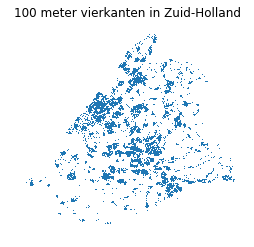

Percentage van de cellen dat gevuld is per attribuut

C28992R100       100.000000
INWONER           99.397702
MAN               87.634309
VROUW             86.985537
INW_014           61.309812
INW_1524          53.855449
INW_2544          67.791947
INW_4564          77.780050
INW_65PL          60.802320
GEBOORTE           1.873815
P_AUTOCHT         85.788378
P_WALLOCH         46.752426
P_NWALLOCH        42.119939
AANTAL_HH         81.397554
TOTHH_EENP        50.959215
TOTHH_MPZK        59.556828
HH_EENOUD         17.728743
HH_TWEEOUD        55.482024
GEM_HH_GR         81.397554
WONING            81.111276
WONVOOR45         19.816336
WON_4564          15.533331
WON_6574          14.672640
WON_7584          14.644756
WON_8594          13.784065
WON_9504          11.690895
WON_0514           9.727851
WON_1524           1.840354
WON_MRGEZ         34.699037
G_GAS_WON         77.201918
G_ELEK_WON        77.443581
UITKMINAOW        34.862624
geometry         100.000000
index_right      100.0

In [19]:
resp = urlopen('http://geodata.nationaalgeoregister.nl/cbsvierkanten100mv2/extract/cbsvierkanten100m2017v1.zip')
zipfile = ZipFile(BytesIO(resp.read()))
zipfile.extractall(path = './data')
vierkanten = gpd.read_file('./data/CBSvierkant100m_2017_v1.shp')
vierkanten.replace(-99997, np.nan, inplace = True)
vierkanten_pzh = gpd.sjoin(vierkanten, provincie, op = 'within')
print(f'''Aantal 100m vierkanten in Zuid-Holland: {vierkanten_pzh.shape[0]}''')
ax = vierkanten_pzh.plot()
ax.set_title('100 meter vierkanten in Zuid-Holland')
ax.set_axis_off()
plt.show()
print('Percentage van de cellen dat gevuld is per attribuut\n')
print((1 - vierkanten_pzh.isnull().sum()/vierkanten_pzh.shape[0]) * 100)
del resp, zipfile, vierkanten, vierkanten_pzh, ax

Voor de 100m vierkantstatistieken ziet het er niet goed uit.      
Is het voor de 500m vierkantstatistieken beter?

Aantal 500m vierkanten in Zuid-Holland: 12740


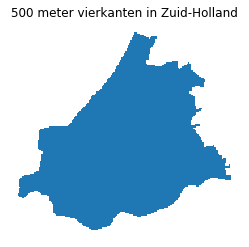

Percentage van de cellen dat gevuld is per attribuut

C28992R500       100.000000
INWONER           50.486656
MAN               45.047096
VROUW             44.230769
INW_014           33.783359
INW_1524          32.990581
INW_2544          34.709576
INW_4564          40.871272
INW_65PL          35.219780
GEBOORTE          16.436421
P_AUTOCHT         44.097331
P_WALLOCH         27.401884
P_NWALLOCH        23.383046
AANTAL_HH         41.868132
TOTHH_EENP        29.270016
TOTHH_MPZK        32.951334
HH_EENOUD         20.745683
HH_TWEEOUD        32.715856
GEM_HH_GR         41.868132
WONING            41.616954
WONVOOR45         21.161695
WON_4564          15.266876
WON_6574          14.293564
WON_7584          14.010989
WON_8594          14.780220
WON_9504          14.222920
WON_0514          13.147567
WON_1524           3.869702
WON_MRGEZ         20.792779
G_GAS_WON         36.624804
G_ELEK_WON        36.734694
UITKMINAOW        24.442700
OAD               64.976452
STED              64.9

In [20]:
resp = urlopen('http://geodata.nationaalgeoregister.nl/cbsvierkanten500mv2/extract/cbsvierkanten500m2017v1.zip')
zipfile = ZipFile(BytesIO(resp.read()))
zipfile.extractall(path = './data')
vierkanten = gpd.read_file('./data/CBSvierkant500m_2017_v1.shp')
vierkanten.replace(-99997, np.nan, inplace = True)
vierkanten_pzh = gpd.sjoin(vierkanten, provincie, op = 'within')
print(f'''Aantal 500m vierkanten in Zuid-Holland: {vierkanten_pzh.shape[0]}''')
ax = vierkanten_pzh.plot()
ax.set_title('500 meter vierkanten in Zuid-Holland')
ax.set_axis_off()
plt.show()
print('Percentage van de cellen dat gevuld is per attribuut\n')
print((1 - vierkanten_pzh.isnull().sum()/vierkanten_pzh.shape[0]) * 100)
del resp, zipfile, vierkanten, vierkanten_pzh, ax

De geografische dekking van de 500m vakken is weliswaar beter, maar de vulling van de attributen is nog steeds slecht.     
Conclusie: buurten is een betere geografische eenheid voor onze analyse dan vierkantstatistieken.

# Dataset wegschrijven

Schrijf de dataset met de buurtgegevens weg als een tab-delimited CSV-bestand.

In [21]:
df.to_csv('./data/buurten.csv', index = False, sep = '\t')

# To Do

* Sommige attributen bevatten lege of missende waarden die gecodeerd zijn als '0', '?' of '-999999990'. Dit moet nog opgeschoond worden.
* Sommige kolommen zijn van elkaar afhankelijk. Dan is het voor de clusteranalyse wellicht handig om een keuze te maken.